In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


## Simulation module implementation

### Description of the simulation module

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

In [2]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5,
              'first_duration': 750}

In [3]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [4]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [57]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials, duration, nstages, sigma, K, initI):
    # Initial run
    first_duration = PARAMS_DICT['first_duration'] #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)
    print(state_init[4])

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        #print('k = ', k, 'state_init[4] =', state_init[4])
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        
        if nstages == 2:
            Keff = 0
        else:
            Keff = K
        
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, Keff, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2


def get_time_lst(ntrials, duration, nstages, sigma, K, initI):
    '''Simulate and return the array of times of threshold crossing'''
    _, _, _, _, _, ylst2 = simulate_trial(ntrials=ntrials, nstages=nstages, duration=duration, 
                                                                       sigma=sigma, K=K, initI=initI)
    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    return times

0.0
Mean tp =  73.15666666666667 std tp =  10.057109701875364


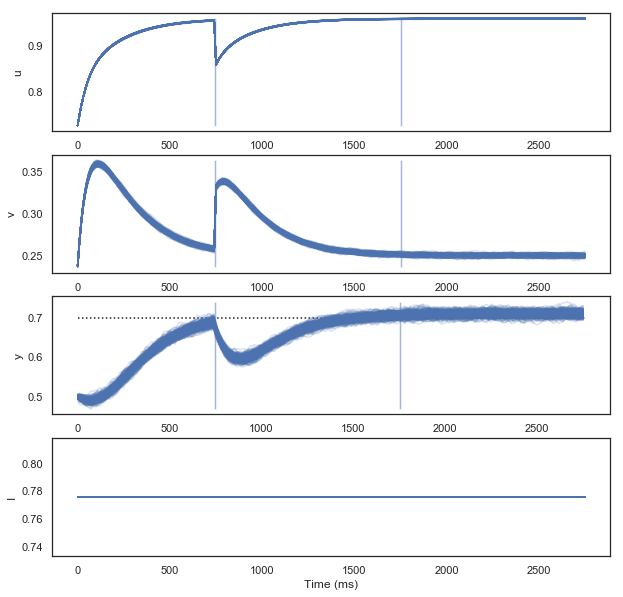

In [78]:
sigma = 0.03
I = 0.7755
K = 5.8
duration = 1000

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=2, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean tp = ', np.mean(times), 'std tp = ', np.std(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data020819_K5_00_I0_77_s0_01_400ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing over a prior

### Ready, Set, Go task

Our prior will be a discrete uniform distribution 600, 700, ..., 1000 ms.

We simulate the 1-2-Go and 1-2-3-Go tasks below and calculate the MSE landscape. $(I, K)$ will be sampled from a grid of values.

In [7]:
def find_rmse(durations, ntrials, nstages, sigma, I, K, return_inf):
    '''Do multiple simulations to find the expected mse of the given set of parameters'''
    mse_total = 0
    for k, dur in enumerate(durations):
        times = get_time_lst(ntrials=ntrials, nstages=nstages,duration=dur, 
                             sigma=sigma, K=K, initI=I)
        # Consider invalid parameters that result in infinite decision times
        if len(times) < ntrials * 0.5:
            return np.inf
        mse_total += np.sum((times * 10 - dur)**2)
    return np.sqrt(mse_total / (ntrials * len(durations)))

In [8]:
def sampling_IK_grid(sigma_lst, Ilst, Klst, durations, nstages, ntrials, return_inf=True):
    '''Perform a simulation to find the rmse of the parameters in the grid.
    Returns a list of nI x nK arrays corresponding to each sigma'''
    # Start of main loop
    mse_arr = np.zeros((len(sigma_lst), len(Ilst), len(Klst)))
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for id_i, I in enumerate(Ilst):
            for id_k, K in enumerate(Klst):
                rmse = find_rmse(durations, ntrials=ntrials, nstages=nstages, 
                                 sigma=sigma, I=I, K=K, return_inf=return_inf)
                mse_arr[id_s, id_i, id_k] = rmse
                print('    I = %.4f, K = %.4f, RMSE = %.4f' % (I, K, rmse))
    return mse_arr

In [50]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)
sigma_lst = [0.005] #np.linspace(0.005, 0.03, 6)

# Define the grid of I and K values
nK = 30
nI = 30
Klst = np.linspace(2, 10, nK)
Ilst = np.linspace(0.76, 0.8, nI)

# Perform the grid simulation
grid_sim_result = sampling_IK_grid(sigma_lst, Ilst, Klst, durations, nstages=4, ntrials=1000,
                                  return_inf=False)

#TODO: Deal with infinite times more properly

*** sigma =  0.005  ***
    I = 0.7600, K = 2.0000, RMSE = 236.1479
    I = 0.7600, K = 2.2759, RMSE = 225.1667
    I = 0.7600, K = 2.5517, RMSE = 214.0523
    I = 0.7600, K = 2.8276, RMSE = 201.6694
    I = 0.7600, K = 3.1034, RMSE = 190.2549
    I = 0.7600, K = 3.3793, RMSE = 178.3947
    I = 0.7600, K = 3.6552, RMSE = 166.5718
    I = 0.7600, K = 3.9310, RMSE = 153.9408
    I = 0.7600, K = 4.2069, RMSE = 141.3860
    I = 0.7600, K = 4.4828, RMSE = 128.7762
    I = 0.7600, K = 4.7586, RMSE = 116.8847
    I = 0.7600, K = 5.0345, RMSE = 104.2500
    I = 0.7600, K = 5.3103, RMSE = 92.5905
    I = 0.7600, K = 5.5862, RMSE = 81.2330
    I = 0.7600, K = 5.8621, RMSE = 71.0046
    I = 0.7600, K = 6.1379, RMSE = 61.8421
    I = 0.7600, K = 6.4138, RMSE = 55.3937
    I = 0.7600, K = 6.6897, RMSE = 53.6131
    I = 0.7600, K = 6.9655, RMSE = 51.4972
    I = 0.7600, K = 7.2414, RMSE = 55.4327
    I = 0.7600, K = 7.5172, RMSE = 59.3790
    I = 0.7600, K = 7.7931, RMSE = 57.7744
    I = 0.7600, K 

    I = 0.7683, K = 4.4828, RMSE = 88.8447
    I = 0.7683, K = 4.7586, RMSE = 80.6398
    I = 0.7683, K = 5.0345, RMSE = 73.4033
    I = 0.7683, K = 5.3103, RMSE = 66.2806
    I = 0.7683, K = 5.5862, RMSE = 60.9126
    I = 0.7683, K = 5.8621, RMSE = 56.7316
    I = 0.7683, K = 6.1379, RMSE = 51.9950
    I = 0.7683, K = 6.4138, RMSE = 52.6082
    I = 0.7683, K = 6.6897, RMSE = 52.6504
    I = 0.7683, K = 6.9655, RMSE = 52.8407
    I = 0.7683, K = 7.2414, RMSE = 55.0641
    I = 0.7683, K = 7.5172, RMSE = 56.8169
    I = 0.7683, K = 7.7931, RMSE = 60.7956
    I = 0.7683, K = 8.0690, RMSE = 57.5060
    I = 0.7683, K = 8.3448, RMSE = 61.3327
    I = 0.7683, K = 8.6207, RMSE = 62.4850
    I = 0.7683, K = 8.8966, RMSE = 64.6472
    I = 0.7683, K = 9.1724, RMSE = 68.5498
    I = 0.7683, K = 9.4483, RMSE = 62.2464
    I = 0.7683, K = 9.7241, RMSE = 65.1351
    I = 0.7683, K = 10.0000, RMSE = 64.1280
    I = 0.7697, K = 2.0000, RMSE = 156.0895
    I = 0.7697, K = 2.2759, RMSE = 148.3558
    I = 

    I = 0.7766, K = 7.2414, RMSE = 55.1672
    I = 0.7766, K = 7.5172, RMSE = 55.2266
    I = 0.7766, K = 7.7931, RMSE = 60.7967
    I = 0.7766, K = 8.0690, RMSE = 59.5693
    I = 0.7766, K = 8.3448, RMSE = 60.5875
    I = 0.7766, K = 8.6207, RMSE = 60.0961
    I = 0.7766, K = 8.8966, RMSE = 63.4486
    I = 0.7766, K = 9.1724, RMSE = 63.0070
    I = 0.7766, K = 9.4483, RMSE = 67.1098
    I = 0.7766, K = 9.7241, RMSE = 66.7933
    I = 0.7766, K = 10.0000, RMSE = 68.2041
    I = 0.7779, K = 2.0000, RMSE = 84.1173
    I = 0.7779, K = 2.2759, RMSE = 77.1956
    I = 0.7779, K = 2.5517, RMSE = 72.1572
    I = 0.7779, K = 2.8276, RMSE = 66.8048
    I = 0.7779, K = 3.1034, RMSE = 62.4362
    I = 0.7779, K = 3.3793, RMSE = 59.0974
    I = 0.7779, K = 3.6552, RMSE = 56.7993
    I = 0.7779, K = 3.9310, RMSE = 54.1034
    I = 0.7779, K = 4.2069, RMSE = 51.7527
    I = 0.7779, K = 4.4828, RMSE = 50.4226
    I = 0.7779, K = 4.7586, RMSE = 48.6276
    I = 0.7779, K = 5.0345, RMSE = 47.4365
    I = 0.

    I = 0.7862, K = 2.0000, RMSE = 305.5991
    I = 0.7862, K = 2.2759, RMSE = 257.9653
    I = 0.7862, K = 2.5517, RMSE = 214.0965
    I = 0.7862, K = 2.8276, RMSE = 186.1852
    I = 0.7862, K = 3.1034, RMSE = 158.2351
    I = 0.7862, K = 3.3793, RMSE = 134.4246
    I = 0.7862, K = 3.6552, RMSE = 116.5091
    I = 0.7862, K = 3.9310, RMSE = 97.1685
    I = 0.7862, K = 4.2069, RMSE = 87.7630
    I = 0.7862, K = 4.4828, RMSE = 77.1412
    I = 0.7862, K = 4.7586, RMSE = 69.5369
    I = 0.7862, K = 5.0345, RMSE = 62.6363
    I = 0.7862, K = 5.3103, RMSE = 54.2548
    I = 0.7862, K = 5.5862, RMSE = 53.0470
    I = 0.7862, K = 5.8621, RMSE = 52.9964
    I = 0.7862, K = 6.1379, RMSE = 51.2412
    I = 0.7862, K = 6.4138, RMSE = 54.1280
    I = 0.7862, K = 6.6897, RMSE = 51.2898
    I = 0.7862, K = 6.9655, RMSE = 54.8795
    I = 0.7862, K = 7.2414, RMSE = 54.9361
    I = 0.7862, K = 7.5172, RMSE = 56.6547
    I = 0.7862, K = 7.7931, RMSE = 57.4038
    I = 0.7862, K = 8.0690, RMSE = 57.6779
    

    I = 0.7945, K = 5.0345, RMSE = 104.3301
    I = 0.7945, K = 5.3103, RMSE = 87.5173
    I = 0.7945, K = 5.5862, RMSE = 70.7654
    I = 0.7945, K = 5.8621, RMSE = 58.8139
    I = 0.7945, K = 6.1379, RMSE = 54.5870
    I = 0.7945, K = 6.4138, RMSE = 52.6693
    I = 0.7945, K = 6.6897, RMSE = 53.2826
    I = 0.7945, K = 6.9655, RMSE = 54.2398
    I = 0.7945, K = 7.2414, RMSE = 55.1453
    I = 0.7945, K = 7.5172, RMSE = 58.0650
    I = 0.7945, K = 7.7931, RMSE = 61.7726
    I = 0.7945, K = 8.0690, RMSE = 59.1199
    I = 0.7945, K = 8.3448, RMSE = 62.0134
    I = 0.7945, K = 8.6207, RMSE = 63.8378
    I = 0.7945, K = 8.8966, RMSE = 65.8532
    I = 0.7945, K = 9.1724, RMSE = 69.8672
    I = 0.7945, K = 9.4483, RMSE = 72.5388
    I = 0.7945, K = 9.7241, RMSE = 84.7699
    I = 0.7945, K = 10.0000, RMSE = 96.3707
    I = 0.7959, K = 2.0000, RMSE = inf
    I = 0.7959, K = 2.2759, RMSE = inf
    I = 0.7959, K = 2.5517, RMSE = inf
    I = 0.7959, K = 2.8276, RMSE = inf
    I = 0.7959, K = 3.103

In [51]:
scipy.io.savemat('PlotTools/IK_grid_040119_1000trialsA.mat', {'MSELST': grid_sim_result,
                                                          'Klst': Klst,
                                                          'Ilst': Ilst,
                                                            'sigma_lst': sigma_lst})

In [48]:
grid_sim_result

array([[[153.34855722, 147.2755241 , 141.35501406, 135.00296293,
         127.95694588, 121.92194224, 116.33787002, 110.46936227,
         104.33158678,  97.90260466,  92.41276968,  85.75931436,
          81.35047634,  76.17965608,  70.22449715,  65.0112298 ,
          62.75699164,  59.28558003,  54.99072649,  54.2228734 ,
          51.39591423,  51.37937329,  51.91069254,  51.61317661,
          52.39160238,  55.18623017,  55.62715164,  55.8705647 ,
          61.04490151,  58.56415286],
        [146.74903748, 140.81725747, 135.00688871, 128.32053616,
         122.91598757, 116.39364244, 111.39613997, 104.79122101,
          99.6243946 ,  93.95658572,  88.03805995,  82.23588025,
          76.8839385 ,  72.35924267,  68.47057762,  63.53487231,
          60.27951559,  57.06645249,  54.33415132,  52.00653805,
          49.90951813,  50.15196905,  50.99470561,  52.72267065,
          52.6444679 ,  53.39681638,  56.49796457,  59.00898237,
          60.27569991,  63.49787398],
        [140.1

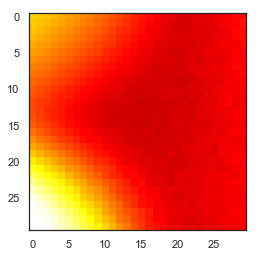

In [46]:
plt.imshow(np.log(grid_sim_result[0]), cmap='hot', vmin=3)

Instead of sampling from a grid of $(I, K)$, here we do a random sampling of $(I, K)$.

In [9]:
# TODO: Check if the old and new versions give the same results
def sampling_IK_optimization_old(sigma_lst, nstages, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    durations = np.linspace(600, 1000, 5)
    ILST = np.zeros((len(sigma_lst), maxiter))
    KLST = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=1, high=10, size=nsamples)
            initIlst = np.random.uniform(low=0.77, high=0.8, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = initIlst[i]
                K = Klst[i]
                mse_total = 0
                #print('        Doing time I = %f. K = %f' % (I, K))
                for k, dur in enumerate(durations):
                    #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                           duration=dur, sigma=sigma, K=K, initI=I)

                    Ylst2 = np.array(ylst2)
                    times = get_times_lst_from_y(np.array(Ylst2))
                    times = times[(times > 0) & (times != np.inf)]

                    if len(times) < 100:
                        mse_total = np.inf
                        #print('no time')
                        break
                    mse_total += np.sum((times * 10 - dur)**2)
                    #print('          times:', times)

                mse_lst[i] = np.sqrt(np.mean(mse_total))
                #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
                #bar.next()
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = initIlst[argmin[0]]
            KLST[id_s][niter] = Kmin
            ILST[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return ILST, KLST

In [60]:
def sampling_IK_optimization(durations, sigma_lst, nstages, ntrials, 
                             Klow, Khigh, Ilow, Ihigh, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    I_optimal = np.zeros((len(sigma_lst), maxiter))
    K_optimal = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
            Ilst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = Ilst[i]
                K = Klst[i]
                rmse = find_rmse(durations, ntrials=ntrials, nstages=nstages, 
                                 sigma=sigma, I=I, K=K, return_inf=True)
                mse_lst[i] = rmse
                #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = Ilst[argmin[0]]
            K_optimal[id_s][niter] = Kmin
            I_optimal[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return I_optimal, K_optimal

In [13]:
durations = np.linspace(600, 1000, 5)
sampling_IK_optimization(durations, [0.0166], nstages=3, ntrials=100, 
                         Klow= 1, Khigh=10, Ilow=0.77, Ihigh=0.8, nsamples=100, maxiter=10)

*** sigma =  0.0166  ***
    Running iteration # 0
        Kmin =  5.215737983811514 , Imin = 0.7808749549979628
    Running iteration # 1
        Kmin =  5.801200810397531 , Imin = 0.7759692648378855
    Running iteration # 2
        Kmin =  6.009774874975201 , Imin = 0.7792339733489502
    Running iteration # 3
        Kmin =  5.424073279017028 , Imin = 0.7809584844517299
    Running iteration # 4
        Kmin =  5.588877919351707 , Imin = 0.779980497161704
    Running iteration # 5
        Kmin =  3.8458550042208026 , Imin = 0.7799999141972802
    Running iteration # 6
        Kmin =  4.158518635701433 , Imin = 0.77793485765365
    Running iteration # 7
        Kmin =  5.9424243337083364 , Imin = 0.7779664407931165
    Running iteration # 8
        Kmin =  5.0419676680901855 , Imin = 0.7786110598365469
    Running iteration # 9
        Kmin =  5.822198723099146 , Imin = 0.7791987189079845


(array([[0.78087495, 0.77596926, 0.77923397, 0.78095848, 0.7799805 ,
         0.77999991, 0.77793486, 0.77796644, 0.77861106, 0.77919872]]),
 array([[5.21573798, 5.80120081, 6.00977487, 5.42407328, 5.58887792,
         3.845855  , 4.15851864, 5.94242433, 5.04196767, 5.82219872]]))

In [66]:
sigma_lst = np.linspace(0.001, 0.04, 6)

Iresults = []
Kresults = []

for i in np.arange(3, 14):
    print('### Number of iterations = ', i)
    a, b = sampling_IK_optimization(sigma_lst, i, nsamples=100, maxiter=10)
    Iresults.append(a)
    Kresults.append(b)

### Number of iterations =  3
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  7.673730767661788 , Imin = 0.7820406065880282
    Running iteration # 1
        Kmin =  8.324289521569298 , Imin = 0.7761776386337822
    Running iteration # 2
        Kmin =  7.85008449339766 , Imin = 0.7798098148823759
    Running iteration # 3
        Kmin =  7.6345425690700415 , Imin = 0.7885053736113045
    Running iteration # 4
        Kmin =  7.6124906385402085 , Imin = 0.786384469916521
    Running iteration # 5
        Kmin =  8.492132297535992 , Imin = 0.7721192860757722
    Running iteration # 6
        Kmin =  8.106508407795484 , Imin = 0.7795008207135184
    Running iteration # 7
        Kmin =  7.737545604258462 , Imin = 0.7814255101489166
    Running iteration # 8
        Kmin =  7.605735201193798 , Imin = 0.7838884364034141
    Running iteration # 9
        Kmin =  8.378245319273846 , Imin = 0.7726549016352496
*** sigma =  0.008799999999999999  ***
    Running iteration # 0
 

        Kmin =  3.9160719580672674 , Imin = 0.7822992359867926
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  4.347565695930931 , Imin = 0.7809632053455122
    Running iteration # 1
        Kmin =  2.891411626993391 , Imin = 0.7803006987449969
    Running iteration # 2
        Kmin =  3.1609216278298646 , Imin = 0.7809005997501666
    Running iteration # 3
        Kmin =  2.714064812308277 , Imin = 0.7807043604859164
    Running iteration # 4
        Kmin =  4.665256184014793 , Imin = 0.7854255190578542
    Running iteration # 5
        Kmin =  2.230996038833317 , Imin = 0.7794012580871142
    Running iteration # 6
        Kmin =  2.8053544256143605 , Imin = 0.7790128398935128
    Running iteration # 7
        Kmin =  2.7918909759584065 , Imin = 0.7792086170388626
    Running iteration # 8
        Kmin =  3.1122299719888993 , Imin = 0.7824873130489469
    Running iteration # 9
        Kmin =  2.664947022329865 , Imin = 0.7786404706027586
*** sigma =  0

        Kmin =  1.838665873940163 , Imin = 0.7846040029922625
### Number of iterations =  6
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  4.8008281270350235 , Imin = 0.7842600546542201
    Running iteration # 1
        Kmin =  4.412516397585406 , Imin = 0.7829001755258567
    Running iteration # 2
        Kmin =  4.6768717571200975 , Imin = 0.7873690727602667
    Running iteration # 3
        Kmin =  4.246549651170017 , Imin = 0.782450442595593
    Running iteration # 4
        Kmin =  5.161514115495913 , Imin = 0.7809279840961586
    Running iteration # 5
        Kmin =  4.029567821470125 , Imin = 0.780794123287461
    Running iteration # 6
        Kmin =  4.279605794613594 , Imin = 0.782003327689772
    Running iteration # 7
        Kmin =  4.39790581076422 , Imin = 0.7802613072177523
    Running iteration # 8
        Kmin =  4.792613517114886 , Imin = 0.7870624454848111
    Running iteration # 9
        Kmin =  4.615877535056741 , Imin = 0.7810774343856078
*** si

        Kmin =  2.092756484660871 , Imin = 0.7807763452087226
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  2.4242694049100537 , Imin = 0.789748492759085
    Running iteration # 1
        Kmin =  3.497242916206817 , Imin = 0.7896850745101444
    Running iteration # 2
        Kmin =  3.5624340216090133 , Imin = 0.7998592161008532
    Running iteration # 3
        Kmin =  3.04979665552465 , Imin = 0.7893813772810747
    Running iteration # 4
        Kmin =  2.8270111461263254 , Imin = 0.7904271742366423
    Running iteration # 5
        Kmin =  2.6459771106748455 , Imin = 0.7757134708435752
    Running iteration # 6
        Kmin =  2.3017515363846055 , Imin = 0.7838273925939915
    Running iteration # 7
        Kmin =  2.671662168131985 , Imin = 0.7934555738641829
    Running iteration # 8
        Kmin =  2.3068317758082446 , Imin = 0.7804310383984262
    Running iteration # 9
        Kmin =  2.1359242201028925 , Imin = 0.7782219032114218
*** sigma =  0

        Kmin =  1.7751414413126745 , Imin = 0.7890733971007038
### Number of iterations =  9
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  3.513613382699635 , Imin = 0.7829472844291644
    Running iteration # 1
        Kmin =  3.1813233088113386 , Imin = 0.7842661274902315
    Running iteration # 2
        Kmin =  3.7641555986324975 , Imin = 0.7840216431186154
    Running iteration # 3
        Kmin =  2.929839666939568 , Imin = 0.7811823804297474
    Running iteration # 4
        Kmin =  3.28115577955009 , Imin = 0.7830963606603735
    Running iteration # 5
        Kmin =  3.0765576664725445 , Imin = 0.7818356277388714
    Running iteration # 6
        Kmin =  3.951862459995916 , Imin = 0.7852963178237854
    Running iteration # 7
        Kmin =  3.9642180144359465 , Imin = 0.7892050333813189
    Running iteration # 8
        Kmin =  3.030605971204968 , Imin = 0.7784475344907322
    Running iteration # 9
        Kmin =  2.8662822544564817 , Imin = 0.7838147600069526

        Kmin =  2.230002525934539 , Imin = 0.7907934244423996
    Running iteration # 9
        Kmin =  1.5388375710274198 , Imin = 0.7812072030702757
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  1.668242677216242 , Imin = 0.7754570714042842
    Running iteration # 1
        Kmin =  2.037626018523023 , Imin = 0.7918834423175277
    Running iteration # 2
        Kmin =  2.050537132491844 , Imin = 0.7972330204291227
    Running iteration # 3
        Kmin =  1.936261683116156 , Imin = 0.7971162991607756
    Running iteration # 4
        Kmin =  1.8360205476980394 , Imin = 0.789292020467803
    Running iteration # 5
        Kmin =  1.3409044930777938 , Imin = 0.7833142990967668
    Running iteration # 6
        Kmin =  1.5186001495711348 , Imin = 0.7812087214278607
    Running iteration # 7
        Kmin =  1.696936970688157 , Imin = 0.7890794469086749
    Running iteration # 8
        Kmin =  2.4279818511940157 , Imin = 0.794870027600784
    Running iter

        Kmin =  1.2642206299999326 , Imin = 0.7876572213761059
    Running iteration # 9
        Kmin =  1.9253361730655036 , Imin = 0.7946742905911894
### Number of iterations =  12
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  2.67913487244346 , Imin = 0.783897112238661
    Running iteration # 1
        Kmin =  3.8172772512464803 , Imin = 0.7917527474385953
    Running iteration # 2
        Kmin =  3.0724660515720474 , Imin = 0.7887368193365764
    Running iteration # 3
        Kmin =  2.7358001945648427 , Imin = 0.7849538673471145
    Running iteration # 4
        Kmin =  2.5521621651752175 , Imin = 0.7838583190806431
    Running iteration # 5
        Kmin =  2.5091735204584706 , Imin = 0.7840808600518222
    Running iteration # 6
        Kmin =  2.680359197169763 , Imin = 0.7864288281795049
    Running iteration # 7
        Kmin =  2.801317392011964 , Imin = 0.7917068615584749
    Running iteration # 8
        Kmin =  2.202484392010545 , Imin = 0.779825260758331

        Kmin =  1.2166242085702246 , Imin = 0.786466081257922
    Running iteration # 8
        Kmin =  1.7983460289950806 , Imin = 0.7848349854449536
    Running iteration # 9
        Kmin =  1.1112976823178586 , Imin = 0.7842667248494247
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  1.312609893279984 , Imin = 0.7928614148101649
    Running iteration # 1
        Kmin =  1.4092912149782086 , Imin = 0.7895736387499278
    Running iteration # 2
        Kmin =  1.3848914824271454 , Imin = 0.7812624090609137
    Running iteration # 3
        Kmin =  2.2440358442150674 , Imin = 0.7845302152595244
    Running iteration # 4
        Kmin =  1.4766004148410552 , Imin = 0.7920976774276964
    Running iteration # 5
        Kmin =  1.063411765681075 , Imin = 0.7883403405377285
    Running iteration # 6
        Kmin =  1.9231865351044344 , Imin = 0.7883729963625988
    Running iteration # 7
        Kmin =  2.037754740042767 , Imin = 0.7791529924437111
    Running 

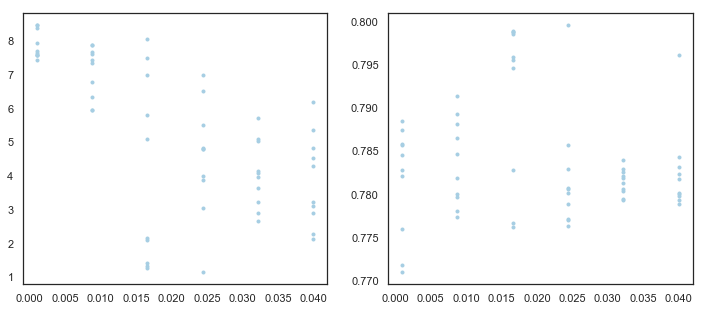

In [37]:
# Color schemes
colors = np.array([[166,206,227],
                [31,120,180],
                [178,223,138],
                [51,160,44],
                [251,154,153]]) / 255

# Load subject fit data
data = scipy.io.loadmat('PlotTools/IK_subject_fit_020519_thres0_7_constant_stage0_750ms_optimized3.mat')
combi_arr = data['combi_arr']

plt.figure(figsize=(12, 5))
# K plotting
plt.subplot(121)
#plt.plot(combi_arr2[:,0], combi_arr[:,2], 'rx')

for i in range(1):
    plt.plot(sigma_lst, Kresults[i], '.', color=colors[i])

# I plotting
plt.subplot(122)

#plt.plot(combi_arr2[:,0], combi_arr[:,1], 'rx')
for i in range(1):
    plt.plot(sigma_lst, Iresults[i], '.', color=colors[i])

In [ ]:
import time

### Doing random sampling for (I,K)

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

sigma_lst = np.linspace(0.005, 0.04, 10)

nsamples = 100
nstages = 10

maxiter = 3
ILST = np.zeros((len(sigma_lst), maxiter))
KLST = np.zeros((len(sigma_lst), maxiter))

#Klst = np.linspace(0.5, 3.5, nsamples)

#bar = Bar('Processing', max=1000)
#bar.start()

start = time.time()

# Do simulation several times to obtain error bars
for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    for niter in range(maxiter):
        print('    Running iteration #', niter)
        # For each iteration, re-pick list of I and K
        Klst = np.random.uniform(low=1, high=6, size=nsamples)
        Ilst = np.random.uniform(low=0.77, high=0.79, size=nsamples)
    
        mse_lst = np.zeros(nsamples)
        for i in range(nsamples):
            I = Ilst[i]
            K = Klst[i]
            mse_total = 0
            #print('        Doing time I = %f. K = %f' % (I, K))
            for k, dur in enumerate(durations):
                #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - dur)**2)

            mse_lst[i] = np.sqrt(np.mean(mse_total))
            #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            #bar.next()
        # Determine the arg-min of the list
        argmin = np.argsort(mse_lst)
        Kmin = Klst[argmin[0]]
        Imin = Ilst[argmin[0]]
        KLST[id_s][niter] = Kmin
        ILST[id_s][niter] = Imin
        print('        Kmin = ', Kmin, ', Imin =', Imin)

end = time.time()
print('Time taken = ', end - start)
# Save simulation results
#scipy.io.savemat('PlotTools/IK_optimization_data_I_0_78_1000trials.mat', {'Ilst': Ilst, 'Klst': Klst, 'KLST': KLST, 
#                                                  'ILST': ILST, 'sigma_lst': sigma_lst, 'PARAMS': PARAMS_DICT})
        
#bar.finish()
    
#plt.plot(Ilst, mse_lst)

*** sigma =  0.005  ***
    Running iteration # 0
        Kmin =  2.9756737834911386 , Imin = 0.7805323734141542
    Running iteration # 1
        Kmin =  3.8889902946802253 , Imin = 0.7821754462710986
    Running iteration # 2
        Kmin =  2.6181556944540483 , Imin = 0.7802945176936206
*** sigma =  0.008888888888888889  ***
    Running iteration # 0
        Kmin =  3.238908181153839 , Imin = 0.776205010753333
    Running iteration # 1
        Kmin =  3.5661133375027365 , Imin = 0.7866042658421407
    Running iteration # 2
        Kmin =  2.297364326199939 , Imin = 0.7768444786233386
*** sigma =  0.012777777777777779  ***
    Running iteration # 0
        Kmin =  2.4533558418962733 , Imin = 0.7811517579197104
    Running iteration # 1
        Kmin =  3.301470144112287 , Imin = 0.7789895258723817
    Running iteration # 2
        Kmin =  2.4762335547942667 , Imin = 0.7785702667443206
*** sigma =  0.016666666666666666  ***
    Running iteration # 0
        Kmin =  2.419460427301033 , 

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

In [200]:
scipy.io.savemat('PlotTools/IK_sim_relationship.mat', {'ILST': ILST, 'KLST': KLST,
                                            'sigma_lst': sigma_lst})

In [64]:
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat',
                    'SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']

[43.38617886 58.10679475 59.85395688 64.82285601 74.16884682]
[43.36735249 57.39464119 67.36902996 70.72701084 73.18907742]
Doing time # 0 = <module 'time' (built-in)>
Doing time # 1 = <module 'time' (built-in)>
Doing time # 2 = <module 'time' (built-in)>
Doing time # 3 = <module 'time' (built-in)>
Doing time # 4 = <module 'time' (built-in)>
RSG results:
Observed mean STD =  89.45925358249178
Simulated mean STD =  96.28334818536098
RSSG results:
Observed mean STD =  99.3156829134492
Simulated mean STD =  96.94717585258348
6758.114451062582
6292.027260788261


43041.10135471616

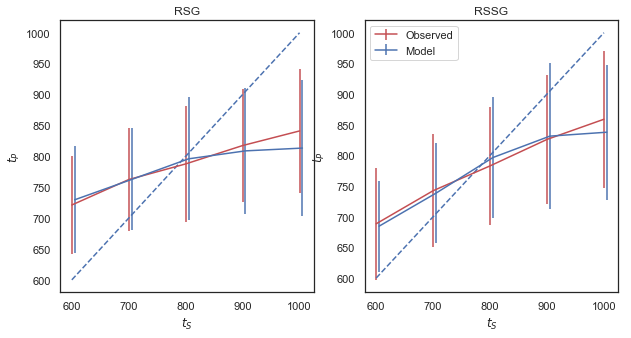

In [25]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = all_subject_files[2]#'SWE_EKF_ObsAct0_20171105.mat'

#     (0.02338383838383839, 0.7791005481106896, 2.3264417072456043)

#I = 0.02338383838383839, K = 5.042443, sigma = 0.020556, error = 20638.847213
#1790.1702682916728
#1132.1413472659856

np.random.seed(111)

sigma_val = sigmas[2]
I_val = Iarr[2]
K_val = Karr[2]

target_std1 = stdtp_in[:,0]
target_std2 = stdtp_in[:,1]
target_time1 = mtp_in[:,0]
target_time2 = mtp_in[:,1]


print(target_std1)
print(target_std2)

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigma_val, K=K_val, initI=I_val)
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, dur in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigma_val, K=K_val, initI=I_val)
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

print(np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2))
print(np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2))
#np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) +\
#                    np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)

np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) +\
                np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)



In [26]:
scipy.io.savemat('PlotTools/GB_sim_results_021119_with_warmup.mat', 
                 {'durations': durations, 'mtp_in': mtp_in, 'prod_time_lst': prod_time_lst,
                 'prod_time_lst2': prod_time_lst2, 'prod_var_lst': prod_var_lst,
                 'prod_var_lst2': prod_var_lst2, 'stdtp_in': stdtp_in, 'tss': tss})

## Behavior fitting protocol

The protocol has two parts: (1) Fitting $(I,K)$ and (2) Fitting $\sigma$. $(I, K)$ is fitted based on the mean of the distribution, while $\sigma$ is fitted based on the standard deviation.

### $(I,K)$ fitting

In [61]:
def do_IK_fitting(subject_file, sigmaval, nsamples, ntrials, Klow, Khigh, Ilow, Ihigh,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - sigmaval: sigma value to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    I, K: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''
    #print('sigmaval = ', sigmaval)
    Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
    Ilst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        Ival = Ilst[k]
        Kval = Klst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=ntrials, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=ntrials, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Continue if there is a nan   
        error1 = (np.array(prod_time_lst) * 10 - target_time1) ** 2
        error2 = (np.array(prod_time_lst2) * 10 - target_time2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
        # Error function to minimize
            error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) +\
                    np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, sigma = %f, error = %f' %(Ival, Kval, sigmaval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal (I, K) = ', Ilst[idx], Klst[idx])
    return Ilst[idx], Klst[idx]

In [62]:
def do_sigma_fitting(subject_file, Ival, Kval, nsamples, ntrials, 
                     low, high, print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - Ival, Kval: I and K values to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    sigma: the optimal sigma to minimize the mse between the std simulated times
    and the std behavioral times of the subject'''

    sigmalst = np.linspace(low, high, nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_std1 = stdtp_in[:,0]
    target_std2 = stdtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        sigmaval = sigmalst[k]
        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))
            
        # Continue if there is a nan   
        error1 = (np.array(prod_var_lst) * 10 - target_std1) ** 2
        error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
            # Error function to minimize
            error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) +\
                    np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)
        
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, sigma = %f, error = %f' %(Ival, Kval, sigmaval, error))
            #print(np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2))
            #print(np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal sigma = ', sigmalst[idx], 'error =', error)
    #print(sum(target_std1))
    #print(sum(target_std2))
    return sigmalst[idx]

In [63]:
def subject_fitting(subject_file, nsamples, nsamples2, ntrials,
                    Klow, Khigh, Ilow, Ihigh, 
                    sigmalow, sigmahigh, print_every=10, niter=5, sigma_init=0.02):
    '''Optimize for the given subject file,
    Returns the fitted combination (sigma, I, K)'''
    sigmaval = sigma_init
    for i in range(niter):
        Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, ntrials=ntrials,
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
        sigmaval = do_sigma_fitting(subject_file, Ival=Ival, Kval=Kval, nsamples=nsamples2, ntrials=ntrials,
                                    low=sigmalow, high=sigmahigh, print_every=print_every)
    # One last round of IK fitting
    Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, ntrials=ntrials,
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
    return sigmaval, Ival, Kval
    
    

In [65]:
all_subject_files

['SWE_EKF_ObsAct0_20171105.mat',
 'CV_EKF_ObsAct0_20171105.mat',
 'GB_EKF_ObsAct0_20171105.mat',
 'LB_EKF_ObsAct0_20171105.mat',
 'PG_EKF_ObsAct0_20171105.mat',
 'SM_EKF_ObsAct0_20171105.mat',
 'TA_EKF_ObsAct0_20171105.mat',
 'VD_EKF_ObsAct0_20171105.mat',
 'VR_EKF_ObsAct0_20171105.mat',
 'SWE_EKF_ObsAct0_20171125.mat',
 'GB_EKF_ObsAct0_20171125.mat']

In [82]:
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat']
np.random.seed(123)

combi_rep = []

tstart = time.time()
for i in range(5):
    combi_collection = []
    for subject_file in all_subject_files:
        print(' ********* Doing subject file %s ************' % subject_file)
        combi = subject_fitting(subject_file, nsamples=100, nsamples2=100, ntrials=100, Klow=1.0, Khigh=8.0, 
                                Ilow=0.77, Ihigh=0.79, sigmalow=0.005, sigmahigh=0.04, print_every=50)
        combi_collection.append(combi)
    combi_rep.append(combi_collection)
    
tend = time.time()

 ********* Doing subject file SWE_EKF_ObsAct0_20171105.mat ************
    I = 0.780263, K = 5.875284, sigma = 0.020000, error = 6251.125405
    I = 0.773319, K = 1.844401, sigma = 0.020000, error = 141164.096581
Optimal (I, K) =  0.7804002030614497 5.27716457474308
    I = 0.780400, K = 5.277165, sigma = 0.005000, error = 6552.168450
    I = 0.780400, K = 5.277165, sigma = 0.022677, error = 43582.651171
Optimal sigma =  0.006767676767676768 error = 100912.8611036356
    I = 0.770311, K = 4.818224, sigma = 0.006768, error = 51634.108531


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan encountered
    I = 0.789605, K = 4.553955, sigma = 0.006768, error = 462402.683127
Optimal (I, K) =  0.7766189484138252 6.13718553937268
    I = 0.776619, K = 6.137186, sigma = 0.005000, error = 7015.479123
    I = 0.776619, K = 6.137186, sigma = 0.022677, error = 58452.395710
Optimal sigma =  0.00888888888888889 error = 92254.0441176912
    I = 0.784299, K = 1.857130, sigma = 0.008889, error = 514265.049724
    I = 0.784481, K = 1.094267, sigma = 0.008889, error = 925574.619827
Optimal (I, K) =  0.776534352877293 6.275037404704935
    I = 0.776534, K = 6.275037, sigma = 0.005000, error = 7308.449196
    I = 0.776534, K = 6.275037, sigma = 0.022677, error = 53826.245252
Optimal sigma =  0.008535353535353537 error = 119624.84652070954
    I = 0.789423, K = 4.176189, sigma = 0.008535, error = 520607.717032
    I = 0.788152, K = 5.140325, sigma = 0.008535, error = 149737.179823
Optimal (I, K) =  0.7775093003677978 5.244749944084859
    I = 0.777509, K = 5.244750, sigma = 0.005000, er

    I = 0.780195, K = 6.369114, sigma = 0.005000, error = 4119.116098
    I = 0.780195, K = 6.369114, sigma = 0.022677, error = 79519.425868
Optimal sigma =  0.005 error = 146402.63875563839
    I = 0.772617, K = 1.208444, sigma = 0.005000, error = 215977.689108
nan encountered
    I = 0.779065, K = 1.674320, sigma = 0.005000, error = 66830.498446
nan encountered
Optimal (I, K) =  0.7801982368627365 5.918955855580606
 ********* Doing subject file PG_EKF_ObsAct0_20171105.mat ************
    I = 0.785543, K = 4.287819, sigma = 0.020000, error = 58658.238616
    I = 0.781765, K = 6.430795, sigma = 0.020000, error = 62444.192679
Optimal (I, K) =  0.7790180108790858 1.5045470890429078
    I = 0.779018, K = 1.504547, sigma = 0.005000, error = 35205.290145
    I = 0.779018, K = 1.504547, sigma = 0.022677, error = 602.242126
Optimal sigma =  0.02055555555555556 error = 8468.757507952727
    I = 0.777345, K = 4.867427, sigma = 0.020556, error = 40381.383517
    I = 0.777976, K = 6.082522, sigm

    I = 0.774057, K = 4.799965, sigma = 0.018081, error = 39637.328408
    I = 0.781264, K = 2.074390, sigma = 0.018081, error = 52431.127758
Optimal (I, K) =  0.7780645443046008 2.3684065426083625
    I = 0.778065, K = 2.368407, sigma = 0.005000, error = 43263.410767
    I = 0.778065, K = 2.368407, sigma = 0.022677, error = 2758.060186
Optimal sigma =  0.026919191919191923 error = 6844.519190912039
    I = 0.779857, K = 6.830827, sigma = 0.026919, error = 49559.149701
    I = 0.788957, K = 4.016887, sigma = 0.026919, error = 111794.430864
Optimal (I, K) =  0.7795988803134014 2.009969272214886
    I = 0.779599, K = 2.009969, sigma = 0.005000, error = 36894.993417
    I = 0.779599, K = 2.009969, sigma = 0.022677, error = 4296.837905
Optimal sigma =  0.026212121212121218 error = 16322.351689357958
    I = 0.777638, K = 2.628434, sigma = 0.026212, error = 9290.571520
    I = 0.787179, K = 4.675265, sigma = 0.026212, error = 63274.720986
Optimal (I, K) =  0.7800166062215302 2.1165334790552

Optimal (I, K) =  0.7793653203549094 3.155238029369915
 ********* Doing subject file GB_EKF_ObsAct0_20171105.mat ************
    I = 0.787472, K = 6.166081, sigma = 0.020000, error = 55916.709399
    I = 0.772287, K = 5.164885, sigma = 0.020000, error = 43198.760210
Optimal (I, K) =  0.7782923765326576 2.773092680862164
    I = 0.778292, K = 2.773093, sigma = 0.005000, error = 38111.934181
    I = 0.778292, K = 2.773093, sigma = 0.022677, error = 2287.528114
Optimal sigma =  0.01984848484848485 error = 13401.428932492901
    I = 0.787993, K = 6.807635, sigma = 0.019848, error = 46902.147492
    I = 0.774495, K = 4.305004, sigma = 0.019848, error = 22288.834565
Optimal (I, K) =  0.777497683689387 2.1002820390949752
    I = 0.777498, K = 2.100282, sigma = 0.005000, error = 42360.282849
    I = 0.777498, K = 2.100282, sigma = 0.022677, error = 789.594805
Optimal sigma =  0.02267676767676768 error = 6756.46361298718
    I = 0.771075, K = 3.741083, sigma = 0.022677, error = 68187.953255
  

    I = 0.779026, K = 4.539113, sigma = 0.006414, error = 8006.301076
nan encountered
nan encountered
    I = 0.782921, K = 4.962598, sigma = 0.006414, error = 26577.924387
Optimal (I, K) =  0.780306785902201 5.891249111567392
    I = 0.780307, K = 5.891249, sigma = 0.005000, error = 4740.912816
    I = 0.780307, K = 5.891249, sigma = 0.022677, error = 78645.577116
Optimal sigma =  0.007474747474747475 error = 153448.80383642373
    I = 0.775555, K = 1.431442, sigma = 0.007475, error = 93458.127632
    I = 0.783749, K = 2.041314, sigma = 0.007475, error = 349026.073940
Optimal (I, K) =  0.7787334420019085 6.909599087193404
    I = 0.778733, K = 6.909599, sigma = 0.005000, error = 5373.460387
    I = 0.778733, K = 6.909599, sigma = 0.022677, error = 74191.740353
Optimal sigma =  0.006060606060606061 error = 136883.79835171113
    I = 0.783549, K = 1.136353, sigma = 0.006061, error = 739372.911661
    I = 0.779198, K = 1.459689, sigma = 0.006061, error = 80096.838448
Optimal (I, K) =  0.

Optimal sigma =  0.005353535353535353 error = 138340.25595285214
    I = 0.786132, K = 6.909256, sigma = 0.005354, error = 12963.235222
nan encountered
    I = 0.788101, K = 1.390650, sigma = 0.005354, error = inf
nan encountered
Optimal (I, K) =  0.7800321575828804 6.000724027207799
    I = 0.780032, K = 6.000724, sigma = 0.005000, error = 3719.198393
    I = 0.780032, K = 6.000724, sigma = 0.022677, error = 74772.699188
Optimal sigma =  0.005 error = 127568.85498439413
    I = 0.776238, K = 6.811432, sigma = 0.005000, error = 7650.532473
nan encountered
    I = 0.782506, K = 6.728844, sigma = 0.005000, error = 6486.954512
nan encountered
nan encountered
nan encountered
Optimal (I, K) =  0.7785166522125496 5.741896220085843
 ********* Doing subject file PG_EKF_ObsAct0_20171105.mat ************
    I = 0.774850, K = 3.796386, sigma = 0.020000, error = 58731.067433
    I = 0.775470, K = 7.812260, sigma = 0.020000, error = 78708.260331
Optimal (I, K) =  0.7788338549886357 1.6868775317368

    I = 0.782358, K = 6.681177, sigma = 0.027273, error = 52946.149614
Optimal (I, K) =  0.7798012129341614 2.391463032574583
    I = 0.779801, K = 2.391463, sigma = 0.005000, error = 36373.234564
    I = 0.779801, K = 2.391463, sigma = 0.022677, error = 4155.492143
Optimal sigma =  0.019494949494949496 error = 14976.900620222892
    I = 0.782261, K = 4.145858, sigma = 0.019495, error = 27657.828517
    I = 0.782750, K = 1.068340, sigma = 0.019495, error = 204410.294466
Optimal (I, K) =  0.7777737478292562 1.4277727799018765
    I = 0.777774, K = 1.427773, sigma = 0.005000, error = 45675.156444
    I = 0.777774, K = 1.427773, sigma = 0.022677, error = 2532.050766
Optimal sigma =  0.02727272727272728 error = 3916.455204505234
    I = 0.774100, K = 1.736368, sigma = 0.027273, error = 56525.938633
    I = 0.784760, K = 2.145790, sigma = 0.027273, error = 102977.170832
Optimal (I, K) =  0.7798610367084058 1.8650586702141263
    I = 0.779861, K = 1.865059, sigma = 0.005000, error = 37204.12

    I = 0.778097, K = 1.885615, sigma = 0.022677, error = 3091.719956
Optimal sigma =  0.019141414141414143 error = 11426.67716771409
    I = 0.778435, K = 1.477033, sigma = 0.019141, error = 4304.683629
    I = 0.785477, K = 2.553319, sigma = 0.019141, error = 163447.043875
Optimal (I, K) =  0.7785309765450817 2.771410212422738
 ********* Doing subject file GB_EKF_ObsAct0_20171105.mat ************
    I = 0.781974, K = 6.980968, sigma = 0.020000, error = 40702.575326
    I = 0.776566, K = 1.037469, sigma = 0.020000, error = 20815.826503
Optimal (I, K) =  0.7777849953678623 2.488538702415223
    I = 0.777785, K = 2.488539, sigma = 0.005000, error = 41015.830420
    I = 0.777785, K = 2.488539, sigma = 0.022677, error = 1065.488022
Optimal sigma =  0.02267676767676768 error = 10864.452783633278
    I = 0.787277, K = 3.174212, sigma = 0.022677, error = 179469.100659
    I = 0.781471, K = 5.136353, sigma = 0.022677, error = 21829.985851
Optimal (I, K) =  0.779386446423416 2.160435111643369

    I = 0.770838, K = 7.891360, sigma = 0.007121, error = 5599.910646
Optimal (I, K) =  0.7788871527635798 6.340356844684032
    I = 0.778887, K = 6.340357, sigma = 0.005000, error = 5774.799138
    I = 0.778887, K = 6.340357, sigma = 0.022677, error = 78452.889465
Optimal sigma =  0.006060606060606061 error = 152656.36179291175
    I = 0.781844, K = 5.940013, sigma = 0.006061, error = 6018.111905
    I = 0.772248, K = 4.083977, sigma = 0.006061, error = 67902.774990
Optimal (I, K) =  0.7807836235570604 6.395378610008011
    I = 0.780784, K = 6.395379, sigma = 0.005000, error = 5162.983462
    I = 0.780784, K = 6.395379, sigma = 0.022677, error = 55672.579241
Optimal sigma =  0.005353535353535353 error = 136847.1118521169
    I = 0.775521, K = 1.716127, sigma = 0.005354, error = 85258.279019
nan encountered
    I = 0.785721, K = 6.082982, sigma = 0.005354, error = 31901.773639
nan encountered
nan encountered
Optimal (I, K) =  0.7800007885986224 6.480285280517596
    I = 0.780001, K = 6

    I = 0.780161, K = 2.428301, sigma = 0.020000, error = 36751.250724
    I = 0.787147, K = 3.611335, sigma = 0.020000, error = 133800.469240
Optimal (I, K) =  0.780179679049282 6.148124907920377
    I = 0.780180, K = 6.148125, sigma = 0.005000, error = 5892.832635
    I = 0.780180, K = 6.148125, sigma = 0.022677, error = 54709.051201
Optimal sigma =  0.006060606060606061 error = 130851.08335592173
    I = 0.787928, K = 5.987755, sigma = 0.006061, error = 78042.399844
    I = 0.788352, K = 1.923802, sigma = 0.006061, error = 2977601.922275
Optimal (I, K) =  0.7773340866580795 6.004600960401454
    I = 0.777334, K = 6.004601, sigma = 0.005000, error = 6320.439429
    I = 0.777334, K = 6.004601, sigma = 0.022677, error = 51385.599691
Optimal sigma =  0.007474747474747475 error = 114795.88874809787
    I = 0.772485, K = 1.567544, sigma = 0.007475, error = 147426.599644
    I = 0.788419, K = 6.594407, sigma = 0.007475, error = 40633.534553
Optimal (I, K) =  0.7784166813436579 4.8861590234

Optimal (I, K) =  0.7800678420041096 5.676660465058454
    I = 0.780068, K = 5.676660, sigma = 0.005000, error = 4746.673685
    I = 0.780068, K = 5.676660, sigma = 0.022677, error = 63214.984519
Optimal sigma =  0.005707070707070707 error = 137455.03904759482
    I = 0.780357, K = 3.381663, sigma = 0.005707, error = 24615.882715
nan encountered
nan encountered
nan encountered
    I = 0.789665, K = 1.945002, sigma = 0.005707, error = inf
Optimal (I, K) =  0.7798049496475575 5.408856186747905
    I = 0.779805, K = 5.408856, sigma = 0.005000, error = 4360.736939
    I = 0.779805, K = 5.408856, sigma = 0.022677, error = 56006.736686
Optimal sigma =  0.005707070707070707 error = 114947.75877450082
    I = 0.776744, K = 5.950090, sigma = 0.005707, error = 8402.207589
nan encountered
nan encountered
    I = 0.777856, K = 6.682654, sigma = 0.005707, error = 5286.808745
Optimal (I, K) =  0.781741521769228 6.3317004755031006
 ********* Doing subject file PG_EKF_ObsAct0_20171105.mat ************

    I = 0.777680, K = 1.099619, sigma = 0.022677, error = 1439.277359
Optimal sigma =  0.02656565656565657 error = 4888.32883926441
    I = 0.783973, K = 4.600634, sigma = 0.026566, error = 41243.121100
    I = 0.777611, K = 2.560263, sigma = 0.026566, error = 7807.477485
Optimal (I, K) =  0.7789864653723224 2.459825156610878
    I = 0.778986, K = 2.459825, sigma = 0.005000, error = 38436.471587
    I = 0.778986, K = 2.459825, sigma = 0.022677, error = 4067.086491
Optimal sigma =  0.02762626262626263 error = 11997.720388799877
    I = 0.785668, K = 3.183250, sigma = 0.027626, error = 91087.048349
    I = 0.781781, K = 7.903893, sigma = 0.027626, error = 51964.889492
Optimal (I, K) =  0.7790675781924028 1.877701029162905
    I = 0.779068, K = 1.877701, sigma = 0.005000, error = 41607.498011
    I = 0.779068, K = 1.877701, sigma = 0.022677, error = 1548.566702
Optimal sigma =  0.02373737373737374 error = 7526.086538104295
    I = 0.780676, K = 2.391083, sigma = 0.023737, error = 12547.50

In [89]:
scipy.io.savemat('PlotTools/IK_subject_fit_040219_thres0_7_constant_stage0_750ms_5reps.mat', 
                 {'combi_rep': np.array(combi_rep), 'all_subject_files': all_subject_files})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


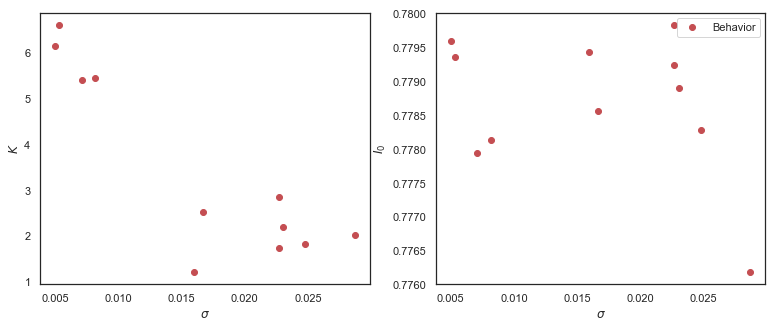

In [17]:
# Collate results
combi_arr = np.array(combi_collection)
sigmas = combi_arr[:,0]
Iarr = combi_arr[:,1]
Karr = combi_arr[:,2]

# Plot the results
plt.figure(figsize=(13,5))
plt.subplot(121)
# Simulation
#for i, sigma in enumerate(sigma_lst):
#    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
# Behavior
plt.plot(sigmas, Karr, 'or')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')

plt.subplot('122')
# Simulation
#for i, sigma in enumerate(sigma_lst):
#    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
# Behavior
plt.plot(sigmas, Iarr, 'or', label='Behavior')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I_0$')
plt.legend()

#plt.savefig('KI_relationship.pdf')

In [86]:
scipy.io.savemat('PlotTools/IK_subject_fit_020419_thres0_7_constant_stage0_750ms.mat', 
                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
scipy.io.savemat('PlotTools/IK_relationship_020419_constant_stage0_750ms.mat',
                {'ILST': ILST, 'KLST': KLST, 'sigma_lst': sigma_lst})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


## Plot model and subject BIAS, VAR, and RMSE

In [18]:
collated_bias_var = []

for i in range(len(all_subject_files)):
    print('Doing subject #%d of %d...' % (i + 1, len(all_subject_files)))
    # Load data for subject
    subject_file = all_subject_files[i]
    sigmaval = combi_arr[i,0]
    Ival = combi_arr[i,1]
    Kval = combi_arr[i,2]

    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

    #1,2,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst.append(np.mean(times))
        prod_var_lst.append(np.std(times))

    #1,2,3,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst2.append(np.mean(times))
        prod_var_lst2.append(np.std(times))

    # Bias
    bias_model1 = np.sum((np.array(prod_time_lst) * 10 - tss.T)**2) / len(tss)
    bias_subject1 = np.sum((target_time1 - tss.T)**2) / len(tss)
    bias_model2 = np.sum((np.array(prod_time_lst2) * 10 - tss.T)**2) / len(tss)
    bias_subject2 = np.sum((target_time2 - tss.T)**2) / len(tss)

    # Variance
    var_model1 = np.sum((np.array(prod_var_lst) * 10)**2) / len(tss)
    var_subject1 = np.sum(stdtp_in[:,0]**2) / len(tss)
    var_model2 = np.sum((np.array(prod_var_lst2) * 10)**2) / len(tss)
    var_subject2 = np.sum(stdtp_in[:,1]**2) / len(tss)
    
    # Collate
    collated_bias_var.append((bias_model1, bias_subject1, bias_model2, bias_subject2,
                             var_model1, var_subject1, var_model2, var_subject2))

collated_bias_var = np.sqrt(np.array(collated_bias_var))

Doing subject #1 of 11...
Doing subject #2 of 11...
Doing subject #3 of 11...
Doing subject #4 of 11...
Doing subject #5 of 11...
Doing subject #6 of 11...
Doing subject #7 of 11...
Doing subject #8 of 11...
Doing subject #9 of 11...
Doing subject #10 of 11...
Doing subject #11 of 11...


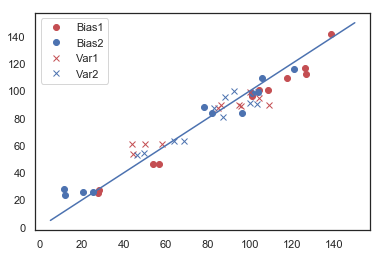

In [19]:
# Plot bias and variance
plt.plot(collated_bias_var[:,0], collated_bias_var[:,1], 'ro', label='Bias1')
plt.plot(collated_bias_var[:,2], collated_bias_var[:,3], 'bo', label='Bias2')
plt.plot(collated_bias_var[:,4], collated_bias_var[:,5], 'rx', label='Var1')
plt.plot(collated_bias_var[:,6], collated_bias_var[:,7], 'bx', label='Var2')
plt.plot([5,150], [5, 150])
plt.legend()

In [21]:
# Save collated bias and variance
suffix = '021119_thres0_7_constant_stage0_750ms_Krange1to8_Irange77to79_sigma005to04.mat'
scipy.io.savemat('PlotTools/IK_subject_fit_' + suffix, 
                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
#scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
#                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst})
scipy.io.savemat('PlotTools/biasvar_' + suffix, 
                 {'collated_bias_var': collated_bias_var, 'all_subject_files': all_subject_files})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


In [62]:
Iresults

[array([[0.78809019, 0.78884011, 0.78673917, 0.78835308, 0.78998716,
         0.7872017 , 0.78831219, 0.78965924, 0.78987637, 0.78751713],
        [0.77876566, 0.7780018 , 0.78034834, 0.78100918, 0.77925654,
         0.7803639 , 0.77809483, 0.77711177, 0.77947069, 0.78027868],
        [0.78002692, 0.7770923 , 0.7785422 , 0.77912482, 0.779219  ,
         0.78007803, 0.77678187, 0.77891956, 0.78097363, 0.78085924],
        [0.78174379, 0.77876805, 0.77882841, 0.77921543, 0.77939682,
         0.77878389, 0.78279536, 0.78107547, 0.78052628, 0.78093314],
        [0.77940451, 0.78033891, 0.78013772, 0.78238905, 0.77953525,
         0.78305766, 0.78372731, 0.77986596, 0.77773973, 0.78352933],
        [0.78052154, 0.78090044, 0.78038872, 0.78520526, 0.78139775,
         0.77789012, 0.77905976, 0.77982284, 0.78101287, 0.78034774]]),
 array([[0.78140293, 0.78440769, 0.7814341 , 0.78167253, 0.78306761,
         0.78194615, 0.78165691, 0.78080198, 0.78094916, 0.78092764],
        [0.77704907, 0.77

In [67]:
suffix = '020719_thres0_7_constant_stage0_750ms_optimized3_Krange1to7B.mat'

scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst,
                'nstages': np.arange(3, 14), 'PARAMS': PARAMS_DICT})
